In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as tf
import torchvision

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp


In [ ]:

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224
TARGET_CROP = torchvision.transforms.CenterCrop((36, 64))

class CachedImageNet(ImageNet):
    def __init__(self, root, split, transform=None, feature_extractor=None, version='0.1'):
        super().__init__(root=root, split=split, transform=transform)
        self.feature_extractor = feature_extractor  # Function to extract features
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        # Cache file path
        cache_path = self._get_cache_path(index)

        # Load feature from cache if it exists

        img = img.unsqueeze(0)  # Add batch dimension
        grayscale_img_rgb = F.rgb_to_grayscale(img, num_output_channels=3).to(device)
        features_path = os.path.join(self.cache_dir, f'feature_{index}.pt')

        if os.path.exists(cache_path):
            saved_features = torch.load(cache_path).to(device)
            if random() < 0.01: # check if the cache is correct
                features = None
                def assign_features(module, input, output):
                    nonlocal features
                    features = output
                hook = self.resnet_layer.register_forward_hook(assign_features)
                
                with torch.no_grad():
                    self.resnet50(grayscale_img_rgb)
                hook.remove()
                assert features is not None
                assert torch.equal(saved_features, features)
            features = saved_features

        else:
            # Compute feature if not cached

            features = None
            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(grayscale_img_rgb)
            hook.remove()
            assert features is not None

            torch.save(features, cache_path)  # Save to cache
        
        # center crop
        target = TARGET_CROP(F.rgb_to_grayscale(img, num_output_channels=1))
        return grayscale_img_rgb, features, target
# Image transformations
train_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Example feature extractor: compute mean/std per channel

def feature_extractor(img):
    img_np = np.array(img)
    mean = np.mean(img_np, axis=(0, 1))
    std = np.std(img_np, axis=(0, 1))
    return torch.tensor(np.concatenate([mean, std]))
# Dataset path


# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split='val',
    transform=train_transforms,
    feature_extractor=feature_extractor,
    version='0.5'
)

from torch.utils.data import random_split, DataLoader

# Define the split sizes
train_size = int(0.8 * len(train_dataset))  # 80% for training
test_size = len(train_dataset) - train_size  # 20% for testing
print("Train size:", train_size)
print("Test size:", test_size)

# Split the dataset
train_subset, test_subset = random_split(train_dataset, [train_size, test_size])

batch_size = 64
# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=batch_size,
    # shuffle=True,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train size: 40000
Test size: 10000


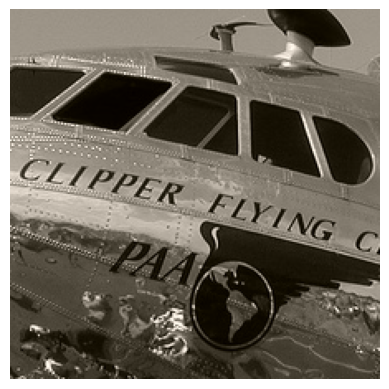

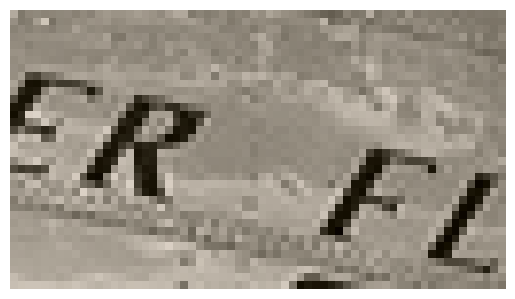

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet normalization mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet normalization std
    img = std * img + mean  # De-normalize
    img = np.clip(img, 0, 1)  # Clip values to [0, 1]
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
images, features, targets = next(data_iter)
show_image(images[2][0, ...])  # Show the first image in the batch
show_image(targets[2][0, ...])  # Show the first image in the batch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as f2

class MLP(nn.Module):
    def __init__(self, dims):
        """
        Single-layer MLP for regression.
        :param input_dim: Input feature size (flattened)
        :param hidden_dim: Number of hidden units
        :param output_dim: Number of outputs (target size)
        :param alpha: Regularization strength
        """
        super(MLP, self).__init__()
        self.lins = nn.ModuleList([nn.Linear(input_dim, output_dim) for input_dim, output_dim in zip(dims[:-1], dims[1:])])
        self.acts = nn.ModuleList([nn.LeakyReLU(.1) for _ in self.lins])

    def forward(self, x):
        for lin, act in zip(self.lins, self.acts):
            x = act(lin(x))
        return x

# Model parameters
feature_shape = (1024, 14, 14)  # Provided feature shape

input_size = feature_shape[0] * feature_shape[1] * feature_shape[2] # 200704

output_size = 36 * 64  # 2304
# Model parameters
mlp_model = MLP([input_size, output_size, output_size]).to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parametrs: ", count_parameters(mlp_model))

criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.0005)

: 

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    mlp_model.train()
    running_loss = 0.0

    # for grayscale_img, features, target in tqdm(train_loader):
    for grayscale_img, features, target in train_loader:
        features = features.to(device)  # Move to device
        target = target.view(target.size(0), -1).to(device)  # Flatten target

        # Flatten features
        features = features.view(features.size(0), -1)

        # Forward pass
        outputs = mlp_model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # constant_guess = torch.mean(target, dim=(-1, -2), keepdim=True)
        constant_guess_loss = criterion(torch.full_like(target, 0), target)
        # print(f"Constant guess loss: {constant_guess_loss.item()}")
        # print(f"Loss: {loss.item()}")


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")



for epoch in range(num_epochs):
    mlp_model.train()
    running_loss = 0.0

    # for grayscale_img, features, target in tqdm(train_loader):
    for grayscale_img, features, target in train_loader:
        features = features.to(device)  # Move to device
        target = target.view(target.size(0), -1).to(device)  # Flatten target

        # Flatten features
        features = features.view(features.size(0), -1)

        # Forward pass
        outputs = mlp_model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # constant_guess = torch.mean(target, dim=(-1, -2), keepdim=True)
        constant_guess_loss = criterion(torch.full_like(target, 0), target)
        # print(f"Constant guess loss: {constant_guess_loss.item()}")
        # print(f"Loss: {loss.item()}")


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
       



  0%|          | 0/20 [00:00<?, ?it/s]


  5%|▌         | 1/20 [00:05<01:53,  5.96s/it]


 10%|█         | 2/20 [00:12<01:57,  6.55s/it]


 10%|█         | 2/20 [00:19<02:57,  9.85s/it]

Test Loss (First 10%): 0.4329


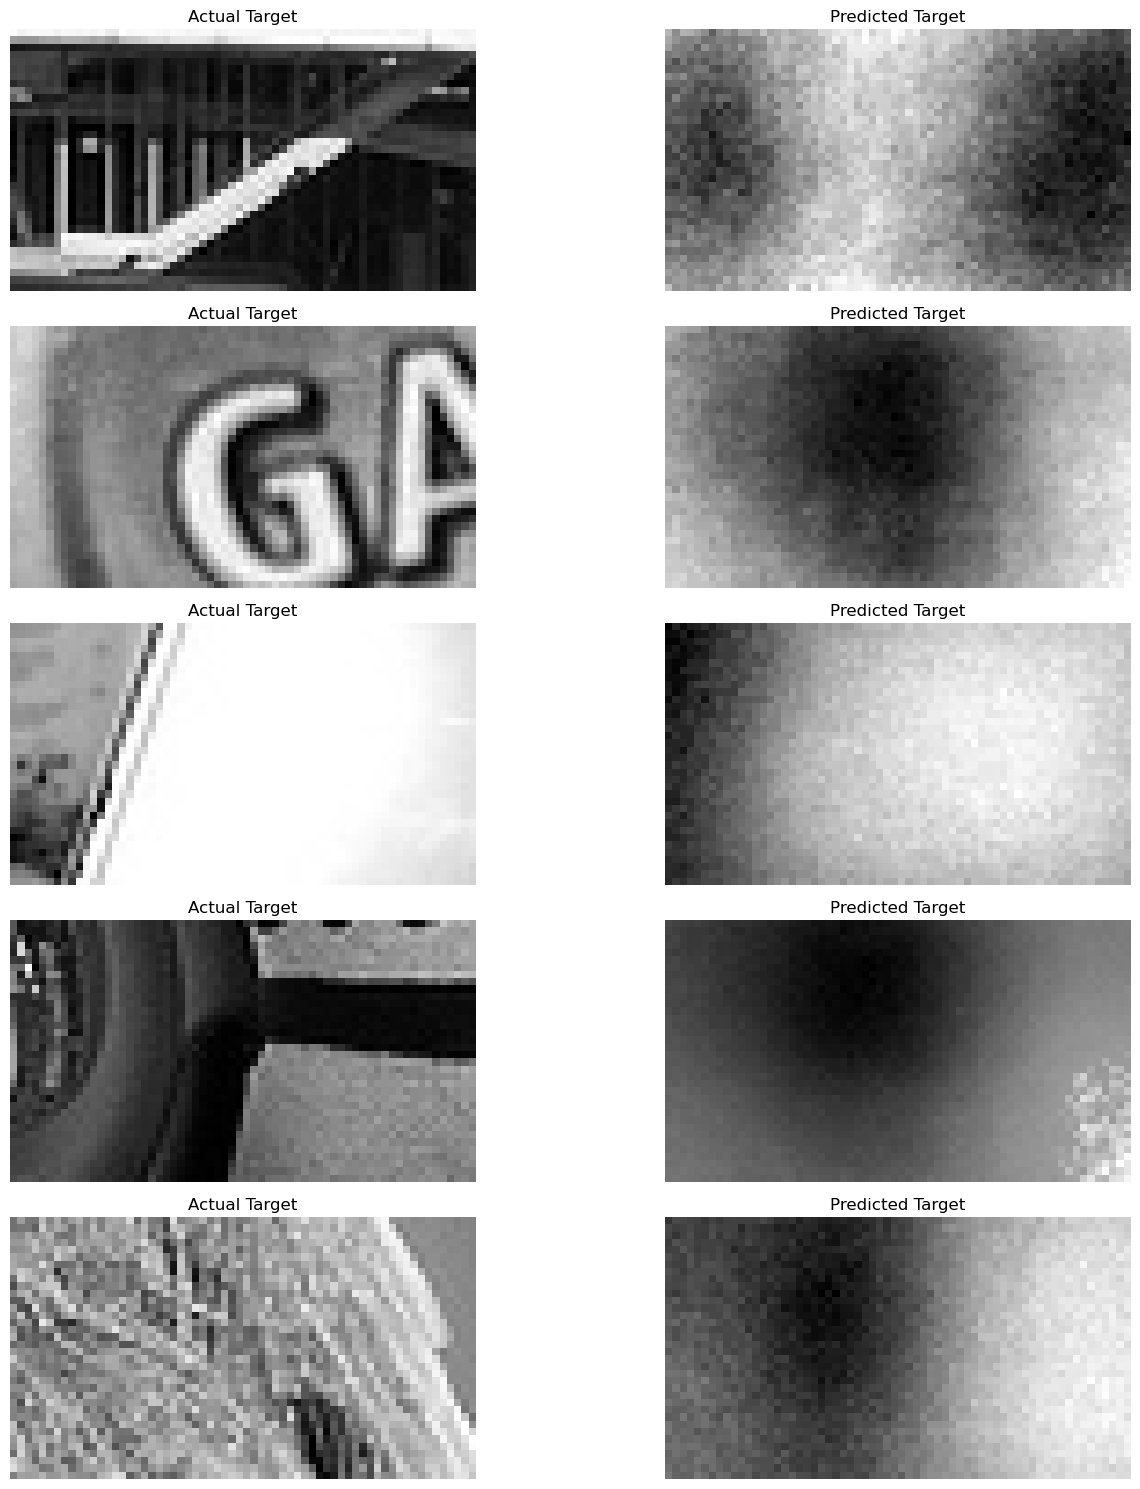

In [5]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, percentage=0.1):
    model.eval()
    test_loss = 0.0
    criterion = nn.MSELoss()
    all_targets = []
    all_predictions = []

    num_batches = int(len(test_loader) * percentage)  # Calculate the number of batches to process
    processed_batches = 0

    with torch.no_grad():
        for grayscale_img, features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.view(target.size(0), -1).to(device)

            # Flatten features
            features = features.view(features.size(0), -1)

            # Predict
            predictions = model(features)
            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(
    mlp_model, test_loader, device, percentage=0.1
)
print(f"Test Loss (First 10%): {test_loss_partial:.4f}")

# Plot Examples
def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].reshape(36, 64), cmap='gray')
        plt.title("Actual Target")
        plt.axis('off')

        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].reshape(36, 64), cmap='gray')
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [6]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-2.6420) tensor(4.1205)
tensor(-2.0337) tensor(2.3987)


In [ ]:

name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(mlp_model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))